In [1]:
import librosa
from IPython.display import Audio,display
import numpy as np
from ipyfilechooser import FileChooser
basepath = "datasets\\archive\\Data\\genres_original\\{tgenre}\\{tgenre}.00001.wav"

In [25]:
# MFCC parameters
N_FFT = 2048
N_MFCC = 13
N_MELS = 10
HOP_LENGTH = 512
NUM_SEGMENTS = 5
DURATION = 29
N_FEATURES = 1058

genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
        "blues",
        "rock"
    ]

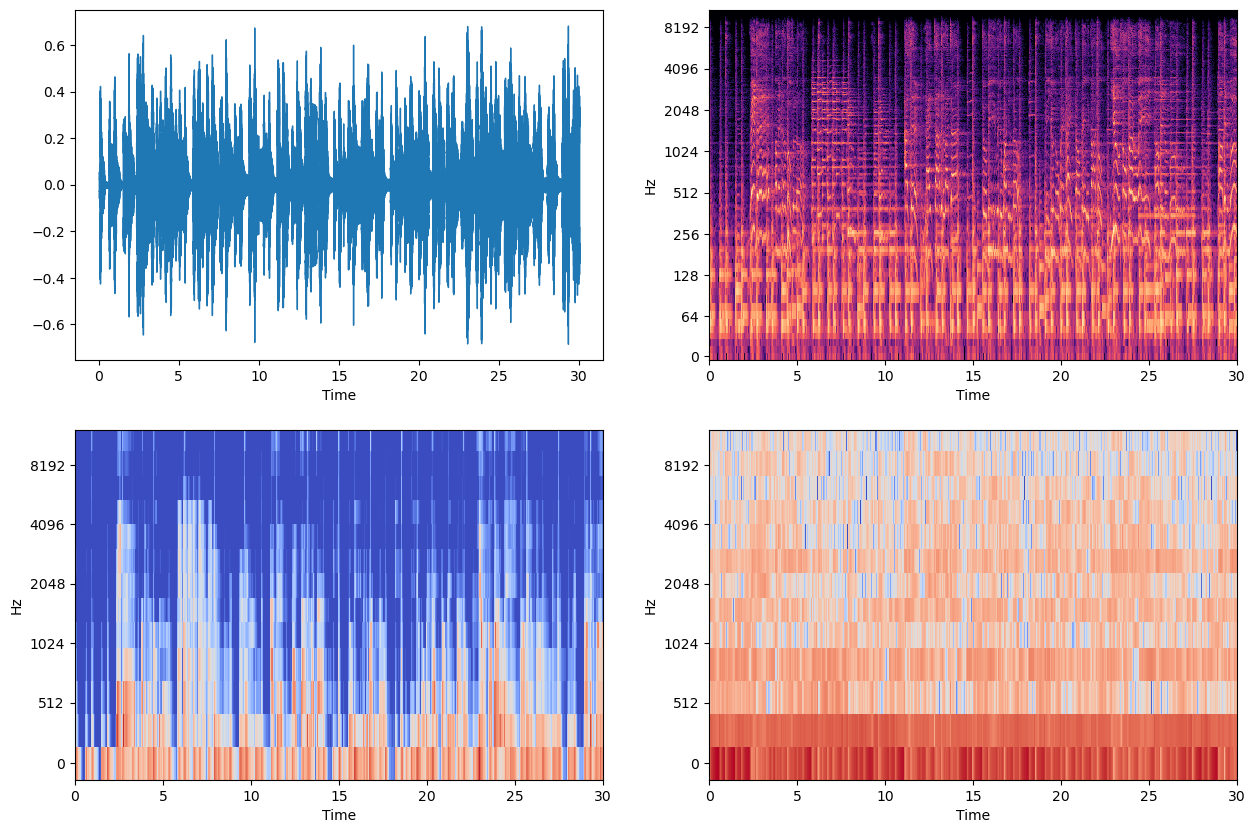

array([[[-339.14639282,  157.71887207,   11.75351143, ...,
           16.00424836,   16.7856462 ,   21.24335166],
        [-223.89967346,  144.83355713,   12.99245071, ...,
           13.36351653,   13.23650901,   33.99977221],
        [-156.06529236,  133.97659302,   11.9312439 , ...,
           15.55266811,   13.80009073,   38.31607872],
        ...,
        [-120.85285187,   89.95761108,  -19.99675751, ...,
           19.92813972,   18.64901642,   44.74055893],
        [-116.6785965 ,   92.65426636,  -21.15874863, ...,
           15.71314866,   17.18209482,   44.831737  ],
        [-117.7157135 ,   91.35990906,  -21.36522293, ...,
           19.28108498,   18.37039872,   44.36381489]]])

<Figure size 1500x1000 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt


def extract_audio_features(file,play=False):
    "Extract audio features from an audio file for genre classification"
    timeseries_length = 128
    features = np.zeros((1, timeseries_length, 33), dtype=np.float64)

    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)
    
    
    if play:
        S,phase = librosa.magphase(librosa.stft(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH))
        magphase = librosa.amplitude_to_db(S, ref=np.max)
        
        fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
        librosa.display.waveshow(y, sr=sr, ax=ax[0,0])
        librosa.display.specshow(magphase,y_axis='log', x_axis='time',ax=ax[0,1])
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MFCC, fmax=8000)
        librosa.display.specshow(data=librosa.amplitude_to_db(mel_spec),sr=sr, x_axis="time", y_axis="mel",ax=ax[1,0])
        librosa.display.specshow(data=librosa.amplitude_to_db(mfcc),sr=sr, x_axis="time", y_axis="mel",ax=ax[1,1])
        display(plt.gcf())
        plt.clf()

    # 1025 + 1 + 12 + 7 + 13 = 1058 features
    features[0, :, 0:13] = mfcc.T[0:timeseries_length, :]
    features[0, :, 13:14] = spectral_center.T[0:timeseries_length, :]
    features[0, :, 14:26] = chroma.T[0:timeseries_length, :]
    features[0, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
    return features



# print("Blues")
extract_audio_features(basepath.format(tgenre="blues"),play=True)
# print("Classical")
# extract_audio_feature(basepath.format(tgenre="classical"),play=True)
# print("Rock")
# extract_audio_feature(basepath.format(tgenre="rock"),play=True)
# print("Jazz")
# extract_audio_feature(basepath.format(tgenre="jazz"),play=True)

In [18]:
from keras.models import model_from_json

def load_model(model_path, weights_path):
    "Load the trained LSTM model from directory for genre classification"
    with open(model_path, "r") as model_file:
        trained_model = model_from_json(model_file.read())
    trained_model.load_weights(weights_path)
    trained_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return trained_model

def get_genre(model, music_path):
    "Predict genre of music using a trained model"
    prediction = model.predict(extract_audio_features(music_path,True))
    predict_genre = genre_list[np.argmax(prediction)]
    for i in genre_list:
        if i in music_path:
            predict_genre = i
    return predict_genre

model = load_model("LSTM-old/weights/model.json", "LSTM-old/weights/model_weights.h5")

In [23]:
fc = FileChooser("datasets/archive/Data/genres_original")
display(fc)

FileChooser(path='C:\Users\joshuaku\Desktop\Final_year_proj\datasets\archive\Data\genres_original', filename='…

Selected file: C:\Users\joshuaku\Desktop\Final_year_proj\datasets\archive\Data\genres_original\metal\metal.00004.wav


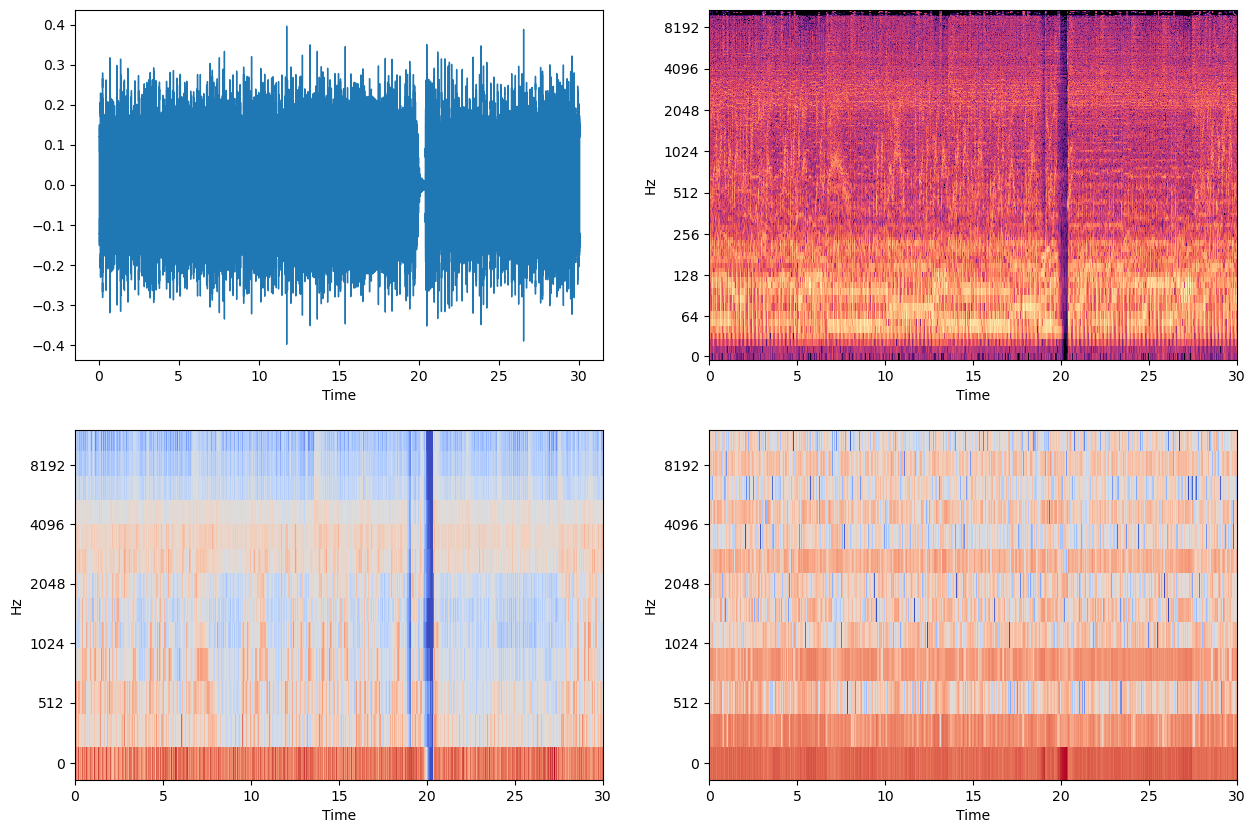

1/1 [==============================] - 0s 105ms/step
----------------------------------------
Predicted Genre: metal
----------------------------------------


<Figure size 1500x1000 with 0 Axes>

In [24]:
filename = fc.selected
print("Selected file:",filename)
predicted_text = get_genre(model, filename)
print("-"*40)
print("Predicted Genre:",predicted_text)
print("-"*40)